In [49]:
from __future__ import print_function

import numpy as np
import cv2 as cv
import video
import sys
import time
# import main()

import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf

In [50]:
printFlag = True
GREEN = (0,255,0)

In [51]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, GREEN)
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, GREEN, -1)
    return vis

In [52]:
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    angle = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = angle * (180/np.pi/2)
    hsv[...,1] = 255
    # hsv[...,2] = np.minimum(v*4, 255)
    hsv[...,2] = cv.normalize(v, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return bgr

In [53]:
# vid = "../../video/stoneturntable1_cropped_center.mp4"
pixel_x, pixel_y = 0, 0
show_hsv, show_glitch = True, False
# vid = input("video_path: ")
# pixel_x, pixel_y = map(int, input('pixel location: ').split())
# show_hsv = map(bool, input("Show HSV?: "))
# show_glitch = map(bool, input("Show glitch?: "))

In [54]:
# cam = video.create_capture(vid)  # cv.VideoCapture()
cam = cv.VideoCapture(0)  # laptop camera
if not cam.isOpened():
    print("Camera open failed!")
    sys.exit()
# 캠의 속성값을 불러온다.
w = round(cam.get(cv.CAP_PROP_FRAME_WIDTH))
h = round(cam.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cam.get(cv.CAP_PROP_FPS) # 카메라에 따라 값이 정상적, 비정상적
# fourcc 값 받아오기, *는 문자를 풀어쓰는 방식, *'DIVX' == 'D', 'I', 'V', 'X'
fourcc = cv.VideoWriter_fourcc(*'DIVX')
# 1프레임과 다음 프레임 사이의 간격 설정
delay = round(1000/fps)
print("fps: ", fps)

# 웹캠으로 찰영한 영상을 저장하기
# cv2.VideoWriter 객체 생성, 기존에 받아온 속성값 입력 
# flowout = cv.VideoWriter('./recorded/'+ vid.rstrip('.mp4') +'_flow.avi', fourcc, fps, (w, h))
flowout = cv.VideoWriter('./recorded/'+'flow.avi', fourcc, fps, (w, h))
# hsvout = cv.VideoWriter('./recorded/'+ vid.rstrip('.mp4') +'_hsv.avi', fourcc, fps, (w, h))
hsvout = cv.VideoWriter('./recorded/'+'hsv.avi', fourcc, fps, (w, h))

# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
_ret, prev = cam.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)

show_hsv = (show_hsv == 'True')
show_glitch = (show_glitch == 'True')
cur_glitch = prev.copy()
magnitude_array = np.array([])
loopcnt = 0
pixelflow = np.zeros((w, h))
print(np.shape(pixelflow))

fps:  15.0
(1920, 1080)


[ WARN:0@25138.949] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created

(<unknown>:15498): GStreamer-CRITICAL **: 20:58:11.143: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@25139.110] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
[ERROR:0@25139.110] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap.cpp (597) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333

In [55]:
while (cam.isOpened):
    # start = time.time()
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    _ret, frame = cam.read()
    
    # prints image size
    # print(np.shape(frame))

    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    if frame is None:
        print("loopcnt: ", loopcnt)
        continue
    loopcnt += 1
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback

    # prev, next: 이전 영상과 현재 영상
    # flow: 계산된 옵티컬플로우
    # pyr_scale: 피라미드 영상 만들 때 축소 비율
    # levels: 피라미드 영상 개수
    # winsize: 평균 윈도우 크기
    # iterations: 각 피라미드 레벨에서 알고리즘 반복 횟수
    # poly_n: 다항식 확장을 위한 이웃 픽셀 크기. 보통 5 or 7.
    # poly_sigma: 가우시안 표준편차. 보통 poly_n = 5이면 1.1, poly_n = 7이면 1.5
    # flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN.
    # flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, pyr_scale = 0.5, \
    #                                    levels = 3, winsize = 15, iterations = 3, \
    #                                    poly_n = 5, poly_sigma = 1.2, flags = 0)
    flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    prevgray = gray
    
    ##### magnitude and angle #####

    # Print cartesian value of magnitude and angle
    magnitudeInCart = flow[..., 0]
    angleInCart = flow[..., 1]
    # if(printFlag):
        # print(magnitudeInCart, angleInCart)

    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True)
    polarFlow = np.stack([magnitude, angle], axis = 2)
    
    # Generating complex array for sound generation
    
    comp_polarFlow = np.vectorize(complex)(polarFlow[...,0], polarFlow[...,1])
    flat_comp_polarFlow = np.ravel(comp_polarFlow, order='C')
    # reduced = np.zeros((7
    
    ampphase = np.zeros_like(polarFlow)
    ampphase[..., 0] = polarFlow[..., 0] * np.cos(np.deg2rad(polarFlow[...,1]))
    ampphase[..., 1] = polarFlow[..., 0] * np.sin(np.deg2rad(polarFlow[...,1]))
    comp_ampphase = np.vectorize(complex)(ampphase[...,0], ampphase[...,1])
    print("asdf: ", comp_ampphase.dtype)
    flat_comp_ampphase = np.ravel(comp_ampphase, order='C')
    # print(flat_comp_ampphase.ndim)
    # if(printFlag):
        # print("magnitude: ", magnitude, "angle: ", angle)
        # print("shape: ", np.shape(magnitude), np.shape(angle))
        
    # prints out polarized magnitude and angle of input pixel position
    pixel_magnitude = magnitude[pixel_x, pixel_y]
    pixel_angle = angle[pixel_x, pixel_y]
    if(printFlag):
        print(pixel_magnitude, pixel_angle)
    magnitude_array = np.append(magnitude_array, pixel_magnitude)

    # prints out the average of polarized magnitude and angle
    avg_magnitude = np.average(magnitude)
    avg_angle = np.average(angle)
    # if printFlag:
        # print(avg_magnitude, avg_angle)
        
    reshaped = flat_comp_ampphase.reshape(-1, 1)
    ##### print #####  
    if loopcnt == 1:
        stacked = reshaped
    else: 
        stacked = np.concatenate([stacked, reshaped], axis = 1)
    
    if loopcnt == 10:
        print(np.shape(flow))
        print(flow)
        print(np.shape(magnitude))
        print(magnitude)
        print(np.shape(angle))
        print(angle)
        print(np.shape(polarFlow))
        print(polarFlow)
        print(np.shape(comp_polarFlow))
        print(comp_polarFlow)
        print(np.shape(comp_ampphase))
        print(comp_ampphase)
        print(np.shape(flat_comp_polarFlow))
        print(flat_comp_polarFlow)
        print(np.shape(flat_comp_ampphase))
        print(flat_comp_ampphase)
    if loopcnt > 150:
        print(stacked)
        print(np.shape(stacked))
        break
    # flowout.write(draw_flow(gray, flow))
    # hsvout.write(draw_hsv(flow))
    # cv.imshow('flow', draw_flow(gray, flow))
    # if show_hsv:
    #     cv.imshow('flow HSV', draw_hsv(flow))
    # if show_glitch:
    #     cur_glitch = warp_flow(cur_glitch, flow)
    #     cv.imshow('glitch', cur_glitch)

    # end = time.time()
    # print(end-start)    
    ch = cv.waitKey(1)
    if ch == ord('q'):
        break
    if ch == ord('1'):
        show_hsv = not show_hsv
        print('HSV flow visualization is', ['off', 'on'][show_hsv])
    if ch == ord('2'):
        show_glitch = not show_glitch
        if show_glitch:
            cur_glitch = frame.copy()
        print('glitch is', ['off', 'on'][show_glitch])
# frame_rate = 0.5
# prev = 0

# while (cam.isOpened):
#     time_elapsed = time.time() - prev
#     res, image = cam.read()

#     if time_elapsed > 1./frame_rate:
#         prev = time.time()
#         # start = time.time()
#         loopcnt += 1
#         # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
#         _ret, frame = cam.read()
        
#         # prints image size
#         # print(np.shape(frame))
        
#         # Converts each frame to grayscale - we previously only converted the first frame to grayscale
#         if frame is None:
#             print("loopcnt: ", loopcnt)
#         gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
#         # Calculates dense optical flow by Farneback method
#         # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback

#         # prev, next: 이전 영상과 현재 영상
#         # flow: 계산된 옵티컬플로우
#         # pyr_scale: 피라미드 영상 만들 때 축소 비율
#         # levels: 피라미드 영상 개수
#         # winsize: 평균 윈도우 크기
#         # iterations: 각 피라미드 레벨에서 알고리즘 반복 횟수
#         # poly_n: 다항식 확장을 위한 이웃 픽셀 크기. 보통 5 or 7.
#         # poly_sigma: 가우시안 표준편차. 보통 poly_n = 5이면 1.1, poly_n = 7이면 1.5
#         # flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN.
#         # flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, pyr_scale = 0.5, \
#         #                                    levels = 3, winsize = 15, iterations = 3, \
#         #                                    poly_n = 5, poly_sigma = 1.2, flags = 0)
#         flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#         prevgray = gray
        
#         ##### magnitude and angle #####

#         # Print cartesian value of magnitude and angle
#         magnitudeInCart = flow[..., 0]
#         angleInCart = flow[..., 1]
#         # if(printFlag):
#             # print(magnitudeInCart, angleInCart)

#         # Computes the magnitude and angle of the 2D vectors
#         magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True)
#         polarFlow = np.stack([magnitude, angle], axis = 2)
        
#         # Generating complex array for sound generation
        
#         comp_polarFlow = np.vectorize(complex)(polarFlow[...,0], polarFlow[...,1])
#         flat_comp_polarFlow = np.ravel(comp_polarFlow, order='C')
#         # reduced = np.zeros((7
        
#         ampphase = np.zeros_like(polarFlow)
#         ampphase[..., 0] = polarFlow[..., 0] * np.cos(np.deg2rad(polarFlow[...,1]))
#         ampphase[..., 1] = polarFlow[..., 0] * np.sin(np.deg2rad(polarFlow[...,1]))
#         comp_ampphase = np.vectorize(complex)(ampphase[...,0], ampphase[...,1])
#         print("asdf: ", comp_ampphase.dtype)
#         flat_comp_ampphase = np.ravel(comp_ampphase, order='C')
#         # print(flat_comp_ampphase.ndim)
#         # if(printFlag):
#             # print("magnitude: ", magnitude, "angle: ", angle)
#             # print("shape: ", np.shape(magnitude), np.shape(angle))
            
#         # prints out polarized magnitude and angle of input pixel position
#         pixel_magnitude = magnitude[pixel_x, pixel_y]
#         pixel_angle = angle[pixel_x, pixel_y]
#         if(printFlag):
#             print(pixel_magnitude, pixel_angle)
#         magnitude_array = np.append(magnitude_array, pixel_magnitude)

#         # prints out the average of polarized magnitude and angle
#         avg_magnitude = np.average(magnitude)
#         avg_angle = np.average(angle)
#         # if printFlag:
#             # print(avg_magnitude, avg_angle)
            
#         reshaped = flat_comp_ampphase.reshape(-1, 1)
#         ##### print #####  
#         if loopcnt == 1:
#             stacked = reshaped
#         else: 
#             stacked = np.concatenate([stacked, reshaped], axis = 1)
        
#         if loopcnt == 10:
#             print(np.shape(flow))
#             print(flow)
#             print(np.shape(magnitude))
#             print(magnitude)
#             print(np.shape(angle))
#             print(angle)
#             print(np.shape(polarFlow))
#             print(polarFlow)
#             print(np.shape(comp_polarFlow))
#             print(comp_polarFlow)
#             print(np.shape(comp_ampphase))
#             print(comp_ampphase)
#             print(np.shape(flat_comp_polarFlow))
#             print(flat_comp_polarFlow)
#             print(np.shape(flat_comp_ampphase))
#             print(flat_comp_ampphase)
#         if loopcnt == 150:
#             print(stacked)
#             print(np.shape(stacked))
#             break
#         # flowout.write(draw_flow(gray, flow))
#         # hsvout.write(draw_hsv(flow))
#         # cv.imshow('flow', draw_flow(gray, flow))
#         # if show_hsv:
#         #     cv.imshow('flow HSV', draw_hsv(flow))
#         # if show_glitch:
#         #     cur_glitch = warp_flow(cur_glitch, flow)
#         #     cv.imshow('glitch', cur_glitch)

#         # end = time.time()
#         # print(end-start)    
#         ch = cv.waitKey(1)
#         if ch == ord('q'):
#             break
#         if ch == ord('1'):
#             show_hsv = not show_hsv
#             print('HSV flow visualization is', ['off', 'on'][show_hsv])
#         if ch == ord('2'):
#             show_glitch = not show_glitch
#             if show_glitch:
#                 cur_glitch = frame.copy()
#             print('glitch is', ['off', 'on'][show_glitch])

asdf:  complex128
1.07348615e-05 64.61343
asdf:  complex128
2.2111506e-05 216.91064
asdf:  complex128
2.63299e-06 281.71753
asdf:  complex128
1.5870175e-05 223.82672
asdf:  complex128
1.5238612e-05 85.07248
asdf:  complex128
1.0909384e-05 252.7888
asdf:  complex128
4.3725704e-06 271.93066
asdf:  complex128
1.15877565e-05 227.5992
asdf:  complex128
2.5259496e-06 129.67657
asdf:  complex128
2.15956e-06 207.13757
(1080, 1920, 2)
[[[-1.92184734e-06 -9.84988219e-07]
  [-1.70898495e-08 -1.95207326e-06]
  [ 7.84863971e-07 -2.84339785e-06]
  ...
  [-1.54070742e-02  1.16634537e-02]
  [-1.74176320e-02  1.04157440e-02]
  [-1.15407193e-02  7.89530016e-03]]

 [[-1.97936515e-06  1.04908293e-06]
  [ 1.17146931e-06 -4.37320637e-07]
  [ 3.26419604e-06 -1.86402247e-06]
  ...
  [-1.94577556e-02  1.42381368e-02]
  [-1.73117518e-02  1.19612822e-02]
  [-6.12582406e-03  8.08835868e-03]]

 [[-5.56209727e-07  5.27263182e-06]
  [ 4.19748631e-06  3.87005639e-06]
  [ 8.49584649e-06  2.45540332e-06]
  ...
  [-3.62

In [56]:
print(np.abs(stacked))
print(np.min(np.abs(stacked)))
print(np.max(np.abs(stacked)))

[[1.07348612e-05 2.21115054e-05 2.63299003e-06 ... 4.80162359e-06
  1.35734196e-07 9.69926762e-07]
 [1.72225555e-05 2.83536594e-05 5.70228925e-06 ... 6.49786460e-06
  1.21629866e-07 8.93094580e-07]
 [2.41077174e-05 3.06124115e-05 8.42646369e-06 ... 8.02231736e-06
  1.07961563e-07 8.05763575e-07]
 ...
 [7.88796739e-05 2.60112787e-05 7.45576402e-05 ... 8.32951564e-05
  3.92009619e-04 9.36541353e-04]
 [7.57319653e-05 2.42185884e-05 4.42604735e-05 ... 6.62451387e-05
  3.09234815e-04 6.73065862e-04]
 [7.19170109e-05 2.48134595e-05 2.36873128e-05 ... 5.01969054e-05
  2.12139019e-04 5.00002209e-04]]
1.6604733382845645e-15
351.4989347635206


In [57]:
istfted = librosa.istft(stacked)
print(istfted)
np.nan_to_num(istfted, copy=False)
print(np.shape(istfted))
print(istfted)

[-3.26929963e-05  7.59471339e-05  4.49729857e-06 ...  3.41952355e-04
 -7.25983565e-04  7.95937191e-05]
(155519850,)
[-3.26929963e-05  7.59471339e-05  4.49729857e-06 ...  3.41952355e-04
 -7.25983565e-04  7.95937191e-05]


In [58]:
ccropped = np.where(istfted>0)
print(ccropped)
print(np.shape(ccropped))
print(type(ccropped))
list = np.asarray(ccropped)
print(list)
print(np.shape(list))
print(type(list))
change = list.reshape(-1)
print(change)
print(np.shape(change))
print(type(change))

x = 10
y = 10
cnt = 22050 * y
cropped = np.zeros((22050 * x))
while cnt < 22050 * (x + y):
    cropped[cnt - 22050 * y] = istfted[change[cnt]]
    cnt+=1

print(cropped)
print(np.shape(cropped))
fs = 22050
sf.write('test.wav', cropped, fs)
ipd.Audio(cropped, rate=fs)
# librosa.display.waveshow(cropped, sr=fs)

(array([        1,         2,         3, ..., 155519845, 155519847,
       155519849]),)
(1, 77704577)
<class 'tuple'>
[[        1         2         3 ... 155519845 155519847 155519849]]
(1, 77704577)
<class 'numpy.ndarray'>
[        1         2         3 ... 155519845 155519847 155519849]
(77704577,)
<class 'numpy.ndarray'>
[9.35754535e-06 8.17709062e-08 3.71306214e-06 ... 2.33374765e-05
 2.83688362e-05 5.82959404e-05]
(220500,)


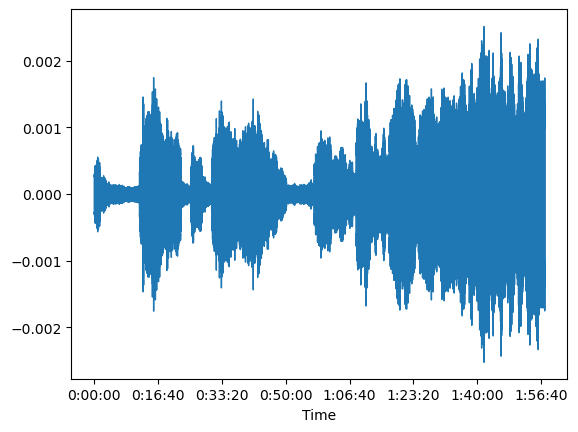

In [59]:
# fs = 460800
# fs = 691200
fs = 22050
sf.write('test.wav', istfted, fs)
ipd.Audio(istfted, rate=fs)
librosa.display.waveshow(istfted, sr=fs)
# sr = 30
# D = np.abs(stacked)
# S_dB = librosa.power_to_db(D, ref=np.max)
# img = librosa.display.specshow(S_dB, y_axis='linear', x_axis='time', hop_length=1, sr=30)
# plt.colorbar(format='%2.0f dB')
# plt.show()

In [60]:
cam.release()
flowout.release()
hsvout.release()
# fs = loopcnt
# freq = magnitude_array
# x1 = np.sin(2*np.pi*freq*np.arange(freq)/fs)
# ipd.Audio(x1, rate = fs)
print(magnitude_array)
print(loopcnt)
print('Done')

[1.07348615e-05 2.21115060e-05 2.63298989e-06 1.58701750e-05
 1.52386119e-05 1.09093844e-05 4.37257040e-06 1.15877565e-05
 2.52594964e-06 2.15955993e-06 1.07247370e-05 1.09121620e-05
 1.22893916e-05 1.36915223e-05 7.84944405e-06 2.68482813e-06
 2.58618888e-06 1.00625693e-05 1.65241145e-05 3.17863924e-05
 1.27877465e-05 1.06806147e-05 2.08051497e-05 1.33038238e-05
 1.09238881e-05 6.00724979e-06 1.22373485e-05 2.27927012e-06
 5.43073475e-06 1.32151408e-05 2.12767668e-06 7.02229909e-06
 7.86449891e-06 2.75232219e-06 9.11103962e-06 6.54247697e-06
 4.13802627e-06 6.98711847e-06 7.05160301e-06 4.33695595e-06
 1.77236586e-06 7.34573632e-06 1.11688250e-05 2.97007568e-06
 8.13660881e-06 6.62063712e-06 2.77967592e-06 6.91079140e-06
 1.01510677e-05 3.87726732e-06 1.59062756e-06 4.60454066e-06
 1.52564617e-05 1.06429698e-05 1.82484860e-06 4.71710848e-07
 2.84297039e-06 3.74883202e-05 3.42562780e-05 1.81210435e-05
 8.84658730e-05 4.55475129e-05 3.45829017e-06 2.71267709e-05
 1.98775342e-05 6.590187